# Process specifications

Dynamically adjusting parameters in a process to meet a specification is critical in designing a production process, and even more so when its under uncertaintly. BioSTEAM groups process specifications into two categories: analytical specifications, and numerical specifications. As the name suggests, an analytical specification is directly solved within a single loop of a system. A numerical specification, on the other hand, is solved numerically by rerunning a unit operation or even by reconverging a recycle system. The following real world examples will explain this in detail.

## Analytical specifications

### Denature ethanol fuel in a bioethanol process

Vary the amount of denaturant to add according to the flow of bioethanol. The final bioethanol product must be 2 wt. % denaturant:

In [1]:
from biosteam import settings, Chemical, Stream, units, main_flowsheet

# First name a new flowsheet
main_flowsheet.set_flowsheet('mix_ethanol_with_denaturant')

# Set the thermodynamic property package.
# In an actual process, much more chemicals
# would be defined, but here we keep it short.
settings.set_thermo(['Water', 'Ethanol', 'Octane'])

# Assume 40 million gal ethanol produced a year
# with 330 operating days
dehydrated_ethanol = Stream('dehydrated_ethanol', T=340,
                            Water=0.1, Ethanol=99.9, units='kg/hr')
operating_days_per_year = 330
dehydrated_ethanol.F_vol = 40e6 / operating_days_per_year
denaturant = Stream('denaturant', Octane=1)
M1 = units.Mixer('M1', ins=(dehydrated_ethanol, denaturant), outs='denatured_ethanol')

# Create the specification function.
@M1.add_specification
def adjust_denaturant_flow():
    denaturant_over_ethanol_flow = 0.02 / 0.98 # A mass ratio
    denaturant.imass['Octane'] = denaturant_over_ethanol_flow * dehydrated_ethanol.F_mass
    M1.run() # Run mass and energy balance
    
# Simulate, and check results. 
M1.simulate()
M1.show(composition=True, flow='kg/hr')

Mixer: M1
ins...
[0] dehydrated_ethanol
    phase: 'l', T: 340 K, P: 101325 Pa
    composition: Water    0.001
                 Ethanol  0.999
                 -------  9.05e+07 kg/hr
[1] denaturant
    phase: 'l', T: 298.15 K, P: 101325 Pa
    composition: Octane  1
                 ------  1.85e+06 kg/hr
outs...
[0] denatured_ethanol
    phase: 'l', T: 339.33 K, P: 101325 Pa
    composition: Water    0.00098
                 Ethanol  0.979
                 Octane   0.02
                 -------  9.23e+07 kg/hr


All specifications are in the unit's specification list:

In [2]:
M1.specification

[[<function __main__.adjust_denaturant_flow()>, ()]]

### Preparing corn slurry in a conventional dry-grind process

The solids content of a corn slurry fed to a conventional dry-grind corn ethanol plant is typically about 32 wt. %. Adjust the flow rate of water mixed with the milled corn for such that the slurry is 32 wt. %:

In [3]:
# First name a new flowsheet
main_flowsheet.set_flowsheet('corn_slurry_example')

# Create a general chemicals to represent the 
# components of corn.
Starch = Chemical.blank('Starch', phase='s')
Fiber = Chemical.blank('Fiber', phase='s')
Oil = Chemical('Oil', search_ID='Oleic_acid')
Water = Chemical('Water')

# The exact properties are not important for 
# the example, so just assume its like water at
# 25 C and 1 atm.
Starch.default()
Fiber.default()

# Set the thermodynamic property package.
# In an actual process, much more chemicals
# would be defined, but here we keep it short.
settings.set_thermo([Starch, Oil, Fiber, Water])

# A typical dry grind process may produce
# 40 million gal of ethanol a year with a
# yield of 2.7 gal ethanol per bushel of corn.
corn_flow_per_year = 40e6 / 2.7 # In bushels
days_per_year = 365
operating_days_per_year = 330
corn_flow_per_day = corn_flow_per_year * days_per_year / operating_days_per_year

# The corn kernel iscomposed of starch (62%), protein and fiber (19%),
# water (15%), and oil (4%).
corn_feed = Stream('corn_feed',
                   Starch=62, Fiber=19, Water=15, Oil=4, units='kg/hr')
corn_feed.set_total_flow(corn_flow_per_day, units='bu/day')

# Water that will be mixed with the milled corn to create the slurry.
slurry_water = Stream('slurry_water', Water=1)
M1 = units.Mixer('M1', ins=(slurry_water, corn_feed), outs='slurry')

@M1.add_specification
def adjust_water_flow():
    F_mass_moisture = corn_feed.imass['Water']
    F_mass_solids = corn_feed.F_mass - F_mass_moisture
    slurry_water.F_mass = F_mass_solids * (1 - 0.32) / 0.32 - F_mass_moisture
    M1._run() # Run mass and energy balance
    
# Simulate, and check results. 
M1.simulate()
M1.show(flow='kg/hr', composition=True)

Mixer: M1
ins...
[0] slurry_water
    phase: 'l', T: 298.15 K, P: 101325 Pa
    composition: Water  1
                 -----  2.87e+07 kg/hr
[1] corn_feed
    phase: 'l', T: 298.15 K, P: 101325 Pa
    composition: Starch  0.62
                 Oil     0.04
                 Fiber   0.19
                 Water   0.15
                 ------  1.73e+07 kg/hr
outs...
[0] slurry
    phase: 'l', T: 298.15 K, P: 101325 Pa
    composition: Starch  0.233
                 Oil     0.0151
                 Fiber   0.0715
                 Water   0.68
                 ------  4.61e+07 kg/hr


## Numerical specifications

### Flash design specification

Let's say we have a mixture of water, ethanol and propanol and we would like to evaporate 50% of the liquid by mass (not by mol). We can solve this problem numerically by testing whether the specification is met at a given temperature:

C:\Users\yrc2\Code\biosteam\biosteam\units\design_tools\pressure_vessel.py:82: CostWarning: <Flash: F1> Vertical vessel weight (949.3 lb) is out of bounds (4200 to 1e+06 lb).
  return method(pressure, diameter, length)
C:\Users\yrc2\Code\biosteam\biosteam\units\design_tools\pressure_vessel.py:82: CostWarning: <Flash: F1> Vertical vessel length (10.5 ft) is out of bounds (12 to 40 ft).
  return method(pressure, diameter, length)


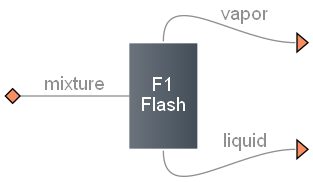

In [4]:
# First name a new flowsheet
main_flowsheet.set_flowsheet('flash_specification_example')

# Set the thermodynamic property package.
# In an actual process, much more chemicals
# would be defined, but here we keep it short.
settings.set_thermo(['Water', 'Ethanol', 'Propanol'])

# Feed stream
mixture = Stream('mixture', T=340,
                 Water=1000, Ethanol=1000, Propanol=1000,
                 units='kg/hr')

# Create a flash vessel
F1 = units.Flash('F1',
                 ins=mixture,
                 outs=('vapor', 'liquid'),
                 T=373, P=101325)

# Set a numerical specification which solves the objective function when called.
@F1.add_bounded_numerical_specification(x0=351.39, x1=373.15, xtol=1e-6)
def f(x):
    # Objective function where f(x) = 0 at a 
    # vapor fraction of 50 wt. %.
    F1.T = x
    F1._run() # IMPORTANT: This runs the mass and energy balance at the new conditions
    feed = F1.ins[0]
    vapor = F1.outs[0]
    V = vapor.F_mass / feed.F_mass 
    return V - 0.5

# Now create the system, simulate, and check results. 
system = main_flowsheet.create_system()
system.simulate()
system.diagram()

In [5]:
print('vapor mass fraction: ', format(F1.outs[0].F_mass / mixture.F_mass, '.0%'))

vapor mass fraction:  50%
